# Pacote de Onda Plana

Neste *notebook* verificamos a qualidade da evolução temporal de um pocate de onda gaussiano feita por três diferentes métodos numéricos:

- Pseudo-Espectral (*Split-Step FFT*)
- Runge-Kutta
- Crank-Nicolson

O pacote de onda gaussiano é do tipo:

$$
\Psi(z,t) = \frac{1}{ \sqrt[4]{ 2 \pi {\sigma_z}^2 }} \exp \left( i k_0 z - \frac{{\left( z - z_0 \right)}^2}{4 {\left(\sigma_z \right)}^2} \right)
$$

Onde $k_0$ é o momento inicial, determinado pela energia do pacote:

$$
E_0 = \frac{\hbar^2 k_0^2}{2 m} \rightarrow k_0 = \sqrt{\frac{2m E_0}{\hbar^2}}
$$

A evolução temporal analítica pode ser dada por:

$$
\Psi(z,t) = \displaystyle\int_{-\infty}^{+\infty} \mathcal{F}[\Psi(z,0)] \, e^{i \varphi(k,t)} \, dk
$$

onde $ \mathcal{F}[\Psi(z,0)]$ é a transformada de Fourier de $\Psi(z,0)$ e $\varphi(k,t)=kz-\omega(k) \,t$.

## Bibliotecas utilizadas

In [40]:
from collections import namedtuple
import numpy as np
import pandas as pd
from scipy.integrate import simps
import scipy.constants as cte
from scipy.fftpack import fft, ifft, fftfreq
from scipy.stats import norm, skewnorm

## Configurações gráficas

In [6]:
import locale
locale.setlocale(locale.LC_NUMERIC, "pt_BR.UTF-8")

import matplotlib.style
import matplotlib as mpl
mpl.style.use('classic')

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('mestrado')

# import matplotlib
# print(plt.style.available)
# print(matplotlib.get_configdir())

## Parâmetros de qualidade

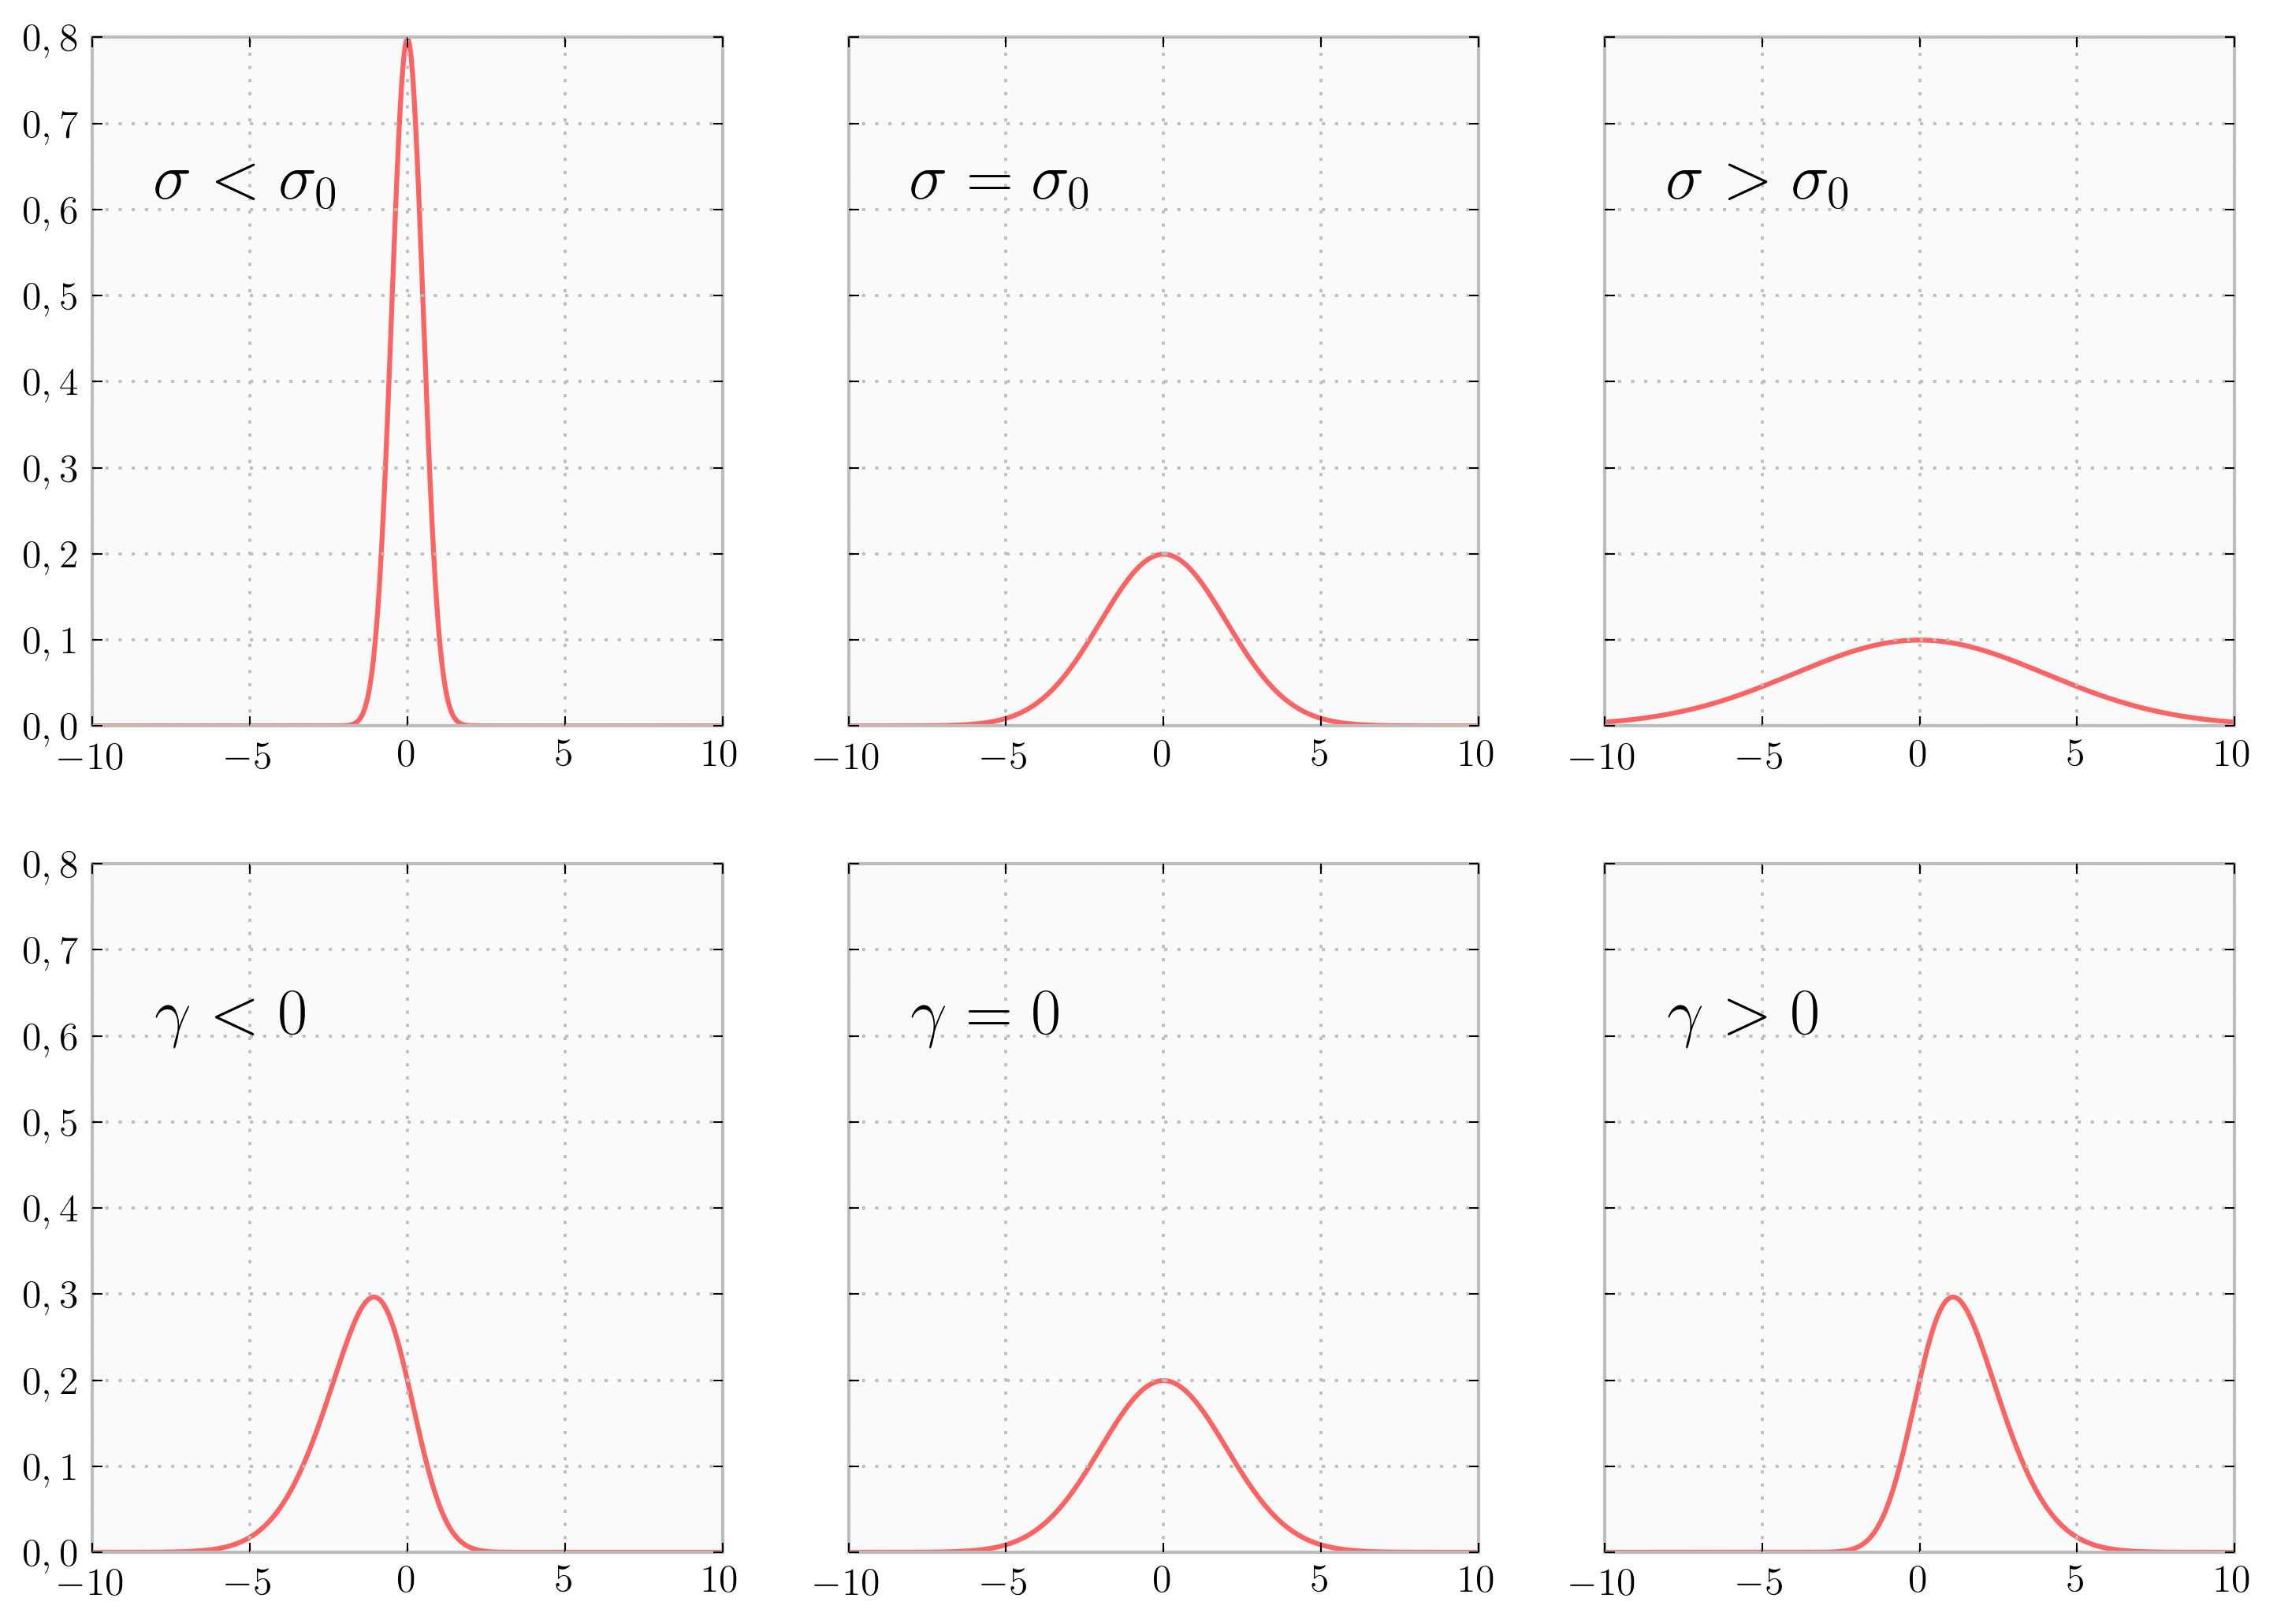

In [7]:
x = np.linspace(-10, 10, 1000)
df = pd.DataFrame({
    'x': x,
    'low_standard_deviation': norm.pdf(x, loc=0, scale=0.5),
    'normal_standard_deviation': norm.pdf(x, loc=0, scale=2.0),
    'high_standard_deviation': norm.pdf(x, loc=0, scale=4.0),
    'negative_skewness': skewnorm.pdf(x, -2, loc=0, scale=2.0),
    'zero_snewness': skewnorm.pdf(x, 0, loc=0, scale=2.0),
    'positive_skewness': skewnorm.pdf(x, 2, loc=0, scale=2.0)
})

f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, sharey=True)
mean, var, skew, kurt = norm.stats(moments='mvsk')
ax1.plot(x, norm.pdf(x, loc=0, scale=0.5), 'r-', alpha=0.6, label='norm pdf')
ax1.text(-8, 0.6, r"$\sigma < \sigma_0$")
ax2.plot(x, norm.pdf(x, loc=0, scale=2.0), 'r-', alpha=0.6, label='norm pdf')
ax2.text(-8, 0.6, r"$\sigma = \sigma_0$")
ax3.plot(x, norm.pdf(x, loc=0, scale=4.0), 'r-', alpha=0.6, label='norm pdf')
ax3.text(-8, 0.6, r"$\sigma > \sigma_0$")

ax4.plot(x, skewnorm.pdf(x, -2, loc=0, scale=2.0),
         'r-', alpha=0.6, label='norm pdf')
ax4.text(-8, 0.6, r"$\gamma < 0$")
ax5.plot(x, skewnorm.pdf(x, 0, loc=0, scale=2.0),
         'r-', alpha=0.6, label='norm pdf')
ax5.text(-8, 0.6, r"$\gamma = 0$")
ax6.plot(x, skewnorm.pdf(x, 2, loc=0, scale=2.0),
         'r-', alpha=0.6, label='norm pdf')
ax6.text(-8, 0.6, r"$\gamma > 0$")
plt.savefig('comparacao_desvpad_obliquidade.png')

## Constantes físicas

In [8]:
 # grandezas de interesse em unidades atomicas
au_l = cte.value('atomic unit of length')
au_t = cte.value('atomic unit of time')
au_e = cte.value('atomic unit of energy')

# outras relacoes de interesse
ev = cte.value('electron volt')
au2ang = au_l / 1e-10
au2ev = au_e / ev

## Funções úteis

In [36]:
def dummy_comma(str_number):
    return str_number.replace(',', '@@').replace('.', ',').replace('@@', '.')

## Evolução analítica

In [47]:
def evolucao_analitica(zi=-20.0, zf=20, E=150.0, deltaz=5.0, L=250.0, N=8192):
    """
    Evolui uma onda com energia [E] e desvio padrão [deltaz] da posição 
    inicial [zi] até a posição final [zf]. A evolução ocorre em um espaço
    unidimensional de lamanho [L] partido em [N] pontos. Esta evolução é
    pseudo-analítica, pois assume que a integração numérica pode ser realizada
    com grande precisão.

    Parâmetros
    ----------
    zi : float
        Posição inicial em Angstrom
    zf : float 
        Posição final em Angstrom
    E : float
        Energia da onda em eV
    deltaz : float
        Desvio padrão em Angstrom
    L : float
        Compimento do sistema em Angstrom
    N : integer
        Número de pontos em que [L] será partido

    Retorna
    -------
    resumo : dict
        Um dicionário com as seguintes chaves:
        - [z_si] malha de pontos em z (SI)
        - [z_au] malha de pontos em z (AU)
        - [z_ang] malha de pontos em z em Angstrom
        - [wave_initial_au] pacote de onda inicial (AU)
        - [wave_final_au] pacote de onda final (AU)
        - [a_initial] norma inicial <psi|psi>
        - [a_final] norma final <psi|psi>
        - [conservation] 100 * [a_final] / [a_initial]
        - [stdev] desvio padrao final em Angstrom
        - [skewness] obliquidade final
        - [time] o tempo físico para a onda ir de [zi] até [zf]
        - [zf_real] a posição final real que pode diferir um pouco de [zf]

    """
    assert zf > zi  # a onda deve ir da esquerda para a direita
    assert E > 0  # energia nula, a onda fica no lugar
    assert L > 0  # o espaço não pode ser nulo
    assert int(np.log2(N)) == np.log2(N)  # N precisa ser potencia de 2
    assert -L/4 < zf < L/4  # a posição final não pode estar próxima as bordas

    # mudando para AU
    L_au = L / au2ang
    E_au = E / au2ev
    deltaz_au = deltaz / au2ang
    zi_au = zi / au2ang
    zf_au = zf / au2ang
    k0_au = np.sqrt(2 * E_au)

    # malha direta e recíproca
    z_au = np.linspace(-L_au/2.0, L_au/2.0, N)
    dz_au = np.abs(z_au[1] - z_au[0])
    k_au = fftfreq(N, d=dz_au)

    # tempos
    time_aux = 1e-18
    time = 5e-18

    # valores iniciais
    zm_au = zi_au
    zm_au_aux = zi_au

    # pacote de onda inicial
    PN = 1 / (2 * np.pi * deltaz_au ** 2) ** (1 / 4)
    psi = PN * np.exp(1j*k0_au*z_au-(z_au-zi_au)**2/(4*deltaz_au**2))
    psi_initial = np.copy(psi)  # salva uma copia

    # valores iniciais
    A = A0 = np.sqrt(simps(np.abs(psi) ** 2, z_au))
    zm_au = zi_au
    stdev_au = deltaz_au
    skewness = 0.0

    while zm_au < zf_au:
        # novo tempo
        t_au = (time) / au_t

        # pacote de onda inicial
        psi = np.copy(psi_initial)

        #####################################################################
        # núcleo da solução pseudo-analítica
        psi_k = fft(psi)
        omega_k = k_au**2 / 2
        psi = ifft(psi_k * np.exp(-1j * omega_k * t_au))
        #####################################################################

        # main indicadores principais
        A2 = simps(np.abs(psi)**2, z_au).real  # quadrado da norma
        A = np.sqrt(A2)  # norma
        psic = np.conjugate(psi)
        zm_au = (simps(psic * z_au * psi, z_au)).real / A2  # <psi|z|psi>

        # ajuste do passo de tempo
        if np.abs(zm_au - zf_au) >= 0.00001:
            if zm_au_aux < zf_au < zm_au or zm_au < zf_au < zm_au_aux:
                aux = (time_aux-time) / 2
            elif zf_au < zm_au and zf_au < zm_au_aux:
                aux = - abs(time_aux-time)
            elif zf_au > zm_au and zf_au > zm_au_aux:
                aux = abs(time_aux-time)

            time_aux = time
            time += aux
            zm_au_aux = zm_au

            continue

        # indicadores secundários
        zm2 = simps(psic * z_au ** 2 * psi, z_au).real / A2
        zm3 = simps(psic * z_au ** 3 * psi, z_au).real / A2
        stdev_au = np.sqrt(np.abs(zm2-zm_au**2))  # desvio padrão
        skewness = (zm3-3*zm_au*stdev_au**2-zm_au**3) / \
            stdev_au**3  # obliquidade

    result = namedtuple(
        'SolucaoAnalitica', 'z_si z_auz_ang wave_initial wave_final a_initial a_final conservation stdev skewness time zf_real')
    result.z_si = z_au * au2ang * 1e-10
    result.z_au = z_au
    result.z_ang = z_au * au2ang
    result.wave_initial = psi_initial
    result.wave_final = psi
    result.a_initial = A0
    result.a_final = A
    result.conservation = 100 * A / A0
    result.stdev = stdev_au * au2ang
    result.skewness = skewness
    result.time = time
    result.zf_real
    return result

In [48]:
# # constantes do problema
# E0 = 150.0  # eV
# delta_x = 5.0  # angstron
# x0 = -20.0  # angstron

# # otimizando
# L = 150  # angstron
# N = 8192  # pontos
# tt = 2.17395e-14  # tempo total de evolução em segundos

# # transforma para unidades atomicas
# L_au = L / au2ang
# E0_au = E0 / au2ev
# delta_x_au = delta_x / au2ang
# t_au = tt / au_t
# x0_au = x0 / au2ang
# k0_au = np.sqrt(2 * E0_au)

# # malhas direta e reciproca
# dx = L / (N-1)
# x_au = np.linspace(-L_au/2.0, L_au/2.0, N)
# dx_au = np.abs(x_au[1] - x_au[0])
# k_au = fftfreq(N, d=dx_au)

# # pacote de onda inicial
# PN = 1/(2*np.pi*delta_x_au**2)**(1/4)
# psi = PN*np.exp(1j*k0_au*x_au-(x_au-x0_au)**2/(4*delta_x_au**2))
# A0 = simps(np.abs(psi)**2, x_au)  # norma inicial
# psi0 = np.copy(psi)  # salva uma copia da onda inicial

# # valores iniciais
# xm = x0_au
# contador = 0
# texto_x = -L/2

# # IMPLEMENTACAO DE FATO DA SOLUCAO PSEUDO ANALITICA
# psi_k = fft(psi)  # FFT do pacote inicial
# omega_k = k_au**2 / 2
# # transformada inversa do pacote de onda multiplicado
# # por uma funcao com a dependencia temporal
# psi = ifft(psi_k * np.exp(-1j * omega_k * t_au))

# # indicadores principaus
# A = simps(np.abs(psi)**2, x_au).real  # norma
# var_norma = 100 * A / A0  # conservacao da norma
# psis = np.conjugate(psi)  # complexo conjugado
# xm = (simps(psis * x_au * psi, x_au)).real / A  # posicao media final <x>

# # indicadores secundarios
# xm2 = simps(psis * x_au**2 * psi, x_au).real / A
# xm3 = simps(psis * x_au**3 * psi, x_au).real / A
# desvpad = np.sqrt(np.abs(xm2 - xm**2))  # desvio padrao
# skewness = (xm3 - 3*xm*desvpad**2-xm**3)/desvpad**3  # obliquidade

res = evolucao_analitica(L=150.0, N=8192)

def as_si(x, ndp):
    s = '{x:0.{ndp:d}e}'.format(x=x, ndp=ndp)
    m, e = s.split('e')
    return r'{m:s}\times 10^{{{e:d}}}'.format(m=m, e=int(e))


fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.set_ylim([-0.005, 0.25])
ax.text(-14, 0.22,
        dummy_comma(r"$\mathbf{L = %.2f}$ \textbf{\AA}" % (L)),
        color='red', fontsize=24)
ax.text(texto_x, 0.235, r"N = %d pontos" % N)
ax.text(texto_x, 0.21, dummy_comma(r"$\Delta z = %.5f$ \AA" % (dx)))
ax.text(texto_x, 0.18,
        dummy_comma(r"$(t_\mathrm{f}-t_\mathrm{i}) = %s$ s" % (as_si(t_au * au_t, 2))))
ax.text(texto_x, 0.15, dummy_comma(
    r"$\langle z_\mathrm{i} \rangle = %.5f$ \AA" % (x0_au * au2ang)))
ax.text(texto_x, 0.12, dummy_comma(
    r"$\langle z_\mathrm{f} \rangle = %.5f$ \AA" % (xm * au2ang)))
ax.text(texto_x, 0.09, dummy_comma(
    r"$\sigma_\mathrm{i} = %.5f$ \AA" % (delta_x_au * au2ang)))
ax.text(texto_x, 0.06, dummy_comma(
    r"$\sigma_\mathrm{f} = %.5f$ \AA" % (desvpad * au2ang)))
ax.text(texto_x, 0.03, dummy_comma(
    r"$\gamma_\mathrm{i} = \gamma_\mathrm{f} = %.5f$" % np.abs(skewness)))
ax.text(texto_x, 0.005, dummy_comma(
    r"$A_\mathrm{f}/A_\mathrm{i} = %.2f$ \%%" % (var_norma)))
plt.gcf().subplots_adjust(bottom=0.15)
plt.xlabel("z (\AA)", fontsize=24)
plt.ylabel(r'$|\Psi (z,t)|^2$', fontsize=24)
line1, = plt.plot(x_au * au2ang, np.abs(psi),
                  lw=2.0, color=(31 / 255, 119/255, 180/255),
                  label='$|\Psi(z,t_\mathrm{f})|^2$')
line2, = plt.plot(x_au * au2ang, np.abs(psi0), lw=2.0,
                  color=(174 / 255, 199/255, 232/255),
                  label='$|\Psi(z,t_\mathrm{i})|^2$')
plt.legend(handles=[line1, line2], loc=1)
plt.savefig('evolucao_pseudo_analitica.png')

KeyboardInterrupt: 

## Método pseudo-espectral

In [ ]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

"""
This module allows to compare Pseudo-Espectral, Runge-Kutta, and
Crank-Nicolson methods of time evolution of a free wave packet
according to the Schroedinger Equation.

/AU/i stands for Atomic Units
/SI/i stands for International System of Units
"""

# libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.integrate import simps
import scipy.constants as cte
from scipy.sparse import diags
from scipy.linalg import inv
from scipy.fftpack import fft, ifft, fftfreq
from scipy.spatial.distance import cdist
from sklearn.preprocessing import StandardScaler
import os, time
from multiprocessing import Pool, TimeoutError
import logging
logger = logging.getLogger('wave-packet-logger')
logger.setLevel(logging.DEBUG)
ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)
formatter = logging.Formatter(\
    '%(asctime)s - %(name)s - %(levelname)s - %(message)s')
ch.setFormatter(formatter)
logger.addHandler(ch)

# matplotlib default config
plt.rcParams['savefig.dpi'] = 75
plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 14, 8
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 22
plt.rcParams['font.size'] = 20
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['font.family'] = "serif"
plt.rcParams['font.serif'] = "computer modern sans serif"
plt.rcParams['text.usetex']=True
plt.rcParams['text.latex.unicode']=True

# AU of interest
au_l = cte.value('atomic unit of length')
au_t = cte.value('atomic unit of time')
au_e = cte.value('atomic unit of energy')

# other constants and relations of interest
ev = cte.value('electron volt')
au2ang = au_l / 1e-10
au2ev = au_e / ev

def analytical_evolution(zi=-20.0, zf=20, E=150.0, deltaz=5.0, \
    L=250.0, N=8192):
    """
    Evolves a free wave packet with energy `E` and dispersion `deltaz`
    from a initial position `zi` until a final position `zf`. 
    The evolution takes place in a space of length `L` split in `N` 
    points. This is a pseudo-analytical solution, since it assumes
    that a numerical integration might be done with great precision.

    Parameters
    ----------
    zi : float
        initial position in Angstrom
    zf : float 
        final position in Angstrom
    E : float
        wave energy in eV
    deltaz : float
        initial dispersion in Angstrom
    L : float
        the length of the space in Angstrom
    N : integer
        the number of points in space
    
    Return
    -------
    summary : dict
        The summary keys are
        - `L` the length of the space
        - `N` the number of points in space
        - `z_si` the z grid in SI
        - `z_au` the z grid in AU
        - `z_ang` the z grid in Angstrom
        - `wave_initial_au` the initial wave packet in AU
        - `wave_final_au` the final wave packet in AU
        - `a_initial` initial <psi|psi>
        - `a_final` final <psi|psi>
        - `conservation` 100 * a_final / a_initial
        - `stdev` the final standard deviation in Angstrom
        - `skewness` the final skewness
        - `time` the time for the wave depart from zi and arrive at zf
        - `zf_real` the real final position, which might differ from zf

    Example
    -------
    >>> from free_wave_packet import *
    >>> analytical_evolution(zi=-20.0, zf=20, L=250.0, N=512, dt=1e-18)
    """
    assert zf > zi # wave should go from left to right
    assert E > 0 # zero energy, wave stays in place
    assert L > 0 # space length must not be null
    assert int(np.log2(N)) == np.log2(N) # must be a power of 2
    assert -L/4 < zf < L/4 # final position might cause errors

    # change to AU
    L_au = L / au2ang
    E_au = E / au2ev
    deltaz_au = deltaz / au2ang
    zi_au = zi / au2ang
    zf_au = zf / au2ang
    k0_au = np.sqrt(2 * E_au)

    # direct and reciproval meshes
    z_au = np.linspace(-L_au/2.0, L_au/2.0, N)
    dz_au = np.abs(z_au[1] - z_au[0])
    k_au = fftfreq(N, d=dz_au)

    # times
    time_aux = 1e-18
    time = 5e-18
    
    # initial values
    zm_au = zi_au
    zm_au_aux = zi_au
    
    # initial wave packet
    PN = 1 / (2 * np.pi * deltaz_au ** 2) ** (1 / 4)
    psi = PN * np.exp(1j*k0_au*z_au-(z_au-zi_au)**2/(4*deltaz_au**2))
    psi_initial = np.copy(psi) # salva uma copia

    # initial values
    A = A0 = np.sqrt(simps(np.abs(psi) ** 2, z_au))
    zm_au = zi_au
    stdev_au = deltaz_au
    skewness = 0.0
    
    while np.abs(zm_au - zf_au) >= 0.00001:
        # new time
        t_au = (time) / au_t
        
        # initial wave packet
        psi = np.copy(psi_initial)

        # acctual pseudo-analytic solotion
        psi_k = fft(psi)
        omega_k = k_au**2 / 2
        psi = ifft(psi_k * np.exp(-1j * omega_k * t_au))

        # main indicators
        A2 = simps(np.abs(psi)**2, z_au).real
        A = np.sqrt(A2)
        psic = np.conjugate(psi)
        zm_au = (simps(psic * z_au * psi, z_au)).real / A2
        
        # adjust time step
        if np.abs(zm_au - zf_au) >= 0.00001:
            if zm_au_aux < zf_au < zm_au or zm_au < zf_au < zm_au_aux:
                aux = (time_aux-time) / 2
            elif zf_au < zm_au and zf_au < zm_au_aux:
                aux = - abs(time_aux-time)
            elif zf_au > zm_au and zf_au > zm_au_aux:
                aux = abs(time_aux-time)
                
            time_aux = time
            time += aux
            zm_au_aux = zm_au
            
            continue
        
        # secondary indicators
        zm2 = simps(psic * z_au ** 2 * psi, z_au).real / A2
        zm3 = simps(psic * z_au ** 3 * psi, z_au).real / A2
        stdev_au = np.sqrt(np.abs(zm2-zm_au**2))
        skewness = (zm3-3*zm_au*stdev_au**2-zm_au**3)/stdev_au**3
    
    return {
        'L': L,
        'N': N,
        'z_si': z_au * au2ang * 1e-10,
        'z_au': z_au,
        'wave_initial': psi_initial,
        'wave_final': psi,
        'a_initial': A0,
        'a_final': A,
        'conservation': 100 * A / A0,
        'stdev': stdev_au * au2ang,
        'skewness': skewness,
        'time': time,
        'zf_real': zm_au * au2ang,
    }

def numerical_evolution(zi=-20.0, zf=20, E=150.0, deltaz=5.0, \
    method='pe', L=100.0, N=256, dt=1e-20):
    """
    Evolves a free wave packet with energy `E` from an initial position
    `zi` until a final position `zf` using the given `method`. 
    The evolution takes place in a space of length `L`
    split in `N` points. Each time step has size `dt`

    Parameters
    ----------
    zi : float
        initial position in Angstrom
    zf : float 
        final position in  Angstrom
    E : float
        wave energy in eV
    deltaz : float
        initial dispersion in Angstrom
    method : string
        it accepts:
        - 'pe' : Pseudo-Espectral
        - 'cn' : Crank-Nicolson
        - 'rk' : Runge-Kutta
    L : float
        the length of the space
    N : integer
        the number of points in space
    dt : float
        the time step

    Return
    -------
    summary : dict
        The summary keys are
        - `L` the length of the space
        - `N` the number of points in space
        - `dt` the time step
        - `method` the method used for evolution
        - `z_au` grid space in Angstrom
        - `z_au` grid space in AU
        - `z_si` grid space in SI
        - `wave_initial` the initial wave packet
        - `wave_final` the final wave packet
        - `a_initial` the initial <psi|psi>
        - `a_final` the final <psi|psi>
        - `conservation` 100 * a_final / a_initial
        - `stdev` the final standard deviation in Angstrom
        - `skewness` the final skewness
        - `zf_real` the real final position, which might differ from zf
        - `time_total` the time the program takes
        - `iterations` the numer of iterations the program makes
    """
    assert method in ['pe', 'cn', 'rk'] # valid methodsassert zf > zi # wave should go from left to right
    assert E > 0 # zero energy, wave stays in place
    assert L > 0 # space length must not be null
    assert int(np.log2(N)) == np.log2(N) # must be a power of 2
    assert -L/4 < zf < L/4 # final position might cause errors

    # change to AU
    L_au = L / au2ang
    dt_au = dt / au_t
    E_au = E / au2ev
    deltaz_au = deltaz / au2ang
    zi_au = zi / au2ang
    zf_au = zf / au2ang
    k0_au = np.sqrt(2 * E_au)

    # direct and reciprocal grids
    z_au = np.linspace(-L_au/2.0, L_au/2.0, N)
    dz_au = np.abs(z_au[1] - z_au[0])
    k_au = fftfreq(N, d=dz_au)

    # start measuring time here because some matrices are very time
    # consuming
    time_inicial = time.time()

    # the evolution operator takes Psi(x,t) into Psi(x,t+dt)
    evolution_operator = lambda p: p

    # runge-kutta 4th order
    if method == 'rk':
        # unstable parameter
        if dt_au / dz_au**2 > 0.5:
            raise Exception("Unstable parameters")
        
        alpha = 1j / (2 * dz_au ** 2)
        beta = - 1j / (dz_au ** 2)
        diagonal_1 = [beta] * N
        diagonal_2 = [alpha] * (N - 1)
        diagonals = [diagonal_1, diagonal_2, diagonal_2]
        D = diags(diagonals, [0, -1, 1]).toarray()
        
        def evolution(p):
            k1 = D.dot(p)
            k2 = D.dot(p + dt_au * k1 / 2)
            k3 = D.dot(p + dt_au * k2 / 2)
            k4 = D.dot(p + dt_au * k3)
            return p + dt_au * (k1 + 2 * k2 + 2 * k3 + k4) / 6
        
        evolution_operator = lambda p: evolution(p)
    
    # crank-nicolson
    if method == 'cn':
        # unstable parameter
        if dt_au / dz_au**2 > 0.5:
            raise Exception("Unstable parameters")
        alpha = - dt_au * (1j / (2 * dz_au ** 2))/2.0
        beta = 1.0 - dt_au * (- 1j / (dz_au ** 2))/2.0
        gamma = 1.0 + dt_au * (- 1j / (dz_au ** 2))/2.0

        diagonal_1 = [beta] * N
        diagonal_2 = [alpha] * (N - 1)
        diagonals = [diagonal_1, diagonal_2, diagonal_2]
        invB = inv(diags(diagonals, [0, -1, 1]).toarray())

        diagonal_3 = [gamma] * N
        diagonal_4 = [-alpha] * (N - 1)
        diagonals_2 = [diagonal_3, diagonal_4, diagonal_4]
        C = diags(diagonals_2, [0, -1, 1]).toarray()
        
        D = invB.dot(C)
        evolution_operator = lambda p: D.dot(p)
    
    # split step
    if method == 'pe':
        exp_v2 = np.ones(N, dtype=np.complex_)
        exp_t = np.exp(- 0.5j * (2 * np.pi * k_au) ** 2 * dt_au)
        evolution_operator = lambda p: \
            exp_v2 * ifft(exp_t * fft(exp_v2 * p))
        
    # initial wave packet
    PN = 1 / (2 * np.pi * deltaz_au ** 2) ** (1 / 4)
    psi = PN * np.exp(1j*k0_au*z_au-(z_au-zi_au)**2/(4*deltaz_au**2))
    psi_initial = np.copy(psi) # stores a copy

    # initial <psi|psi>
    A = A0 = np.sqrt(simps(np.abs(psi) ** 2, z_au))

    # initial values
    zm_au = zi_au
    stdev_au = deltaz_au
    skewness = 0.0
    iterations = 0

    while zm_au < zf_au:
        psi = evolution_operator(psi)
        iterations += 1

        # if the wave walks to the worng side, inverst the wave vector
        # it is expect to happen one time in the most, and in the
        # beginning
        if zm_au < zi_au:
            k0_au *= -1.0
            psi = PN*np.exp(1j*k0_au*z_au-(z_au-zi_au)**2/(4*deltaz**2))
            zm_au = zi_au
            continue

        # main indicators
        A2 = simps(np.abs(psi) ** 2, z_au).real
        A = np.sqrt(A2)
        psic = np.conjugate(psi)

        # average position of psi
        zm_au = (simps(psic * z_au * psi, z_au)).real / A2

        # stop measuring time (it might be the end)
        time_final = time.time()
        
        # if the final position has been achieved of the time
        # is greater than 1000 seconds
        if zm_au >= zf_au or time_final - time_inicial > 1000:
            # secondary indicators
            zm2 = simps(psic * z_au ** 2 * psi, z_au).real / A2
            zm3 = simps(psic * z_au ** 3 * psi, z_au).real / A2
            stdev_au = np.sqrt(np.abs(zm2-zm_au**2))
            skewness = (zm3-3*zm_au*stdev_au**2-zm_au**3)/stdev_au**3
            
            if time_final - time_inicial > 1000:
                break

    program_total_time = time_final - time_inicial
    
    return {
        'L': L,
        'N': N,
        'dt': dt,
        'method': method,
        'z_ang': z_au * au2ang,
        'z_si': z_au * au2ang * 1e-10,
        'z_au': z_au,
        'wave_initial': psi_initial,
        'wave_final': psi,
        'a_initial': A0,
        'a_final': A,
        'conservation': 100 * A / A0,
        'stdev': stdev_au * au2ang,
        'skewness': skewness,
        'time_total': program_total_time,
        'iterations': iterations,
        'zf_real': zm_au * au2ang
    }

if __name__ == '__main__':

    methods = ['pe', 'cn', 'rk']
    steps = [1e-20, 5e-20, 1e-19, 5e-19, 1e-18, 5e-18, 1e-17, \
        5e-17, 1e-16, 5e-16]
    combinations = []
    
    for method in methods:
        for L in np.linspace(100,1000,7):
            for N in [2**n for n in range(8,13)]:
                for dt in steps:
                    if dt < 1e-19 and method != 'pe':
                        continue
                    combinations.append((method, L, N, dt))

    def evolve_comb(combination):
        try:
            method, L, N, dt = combination
            res = numerical_evolution(L=L, N=N, dt=dt, method=method)
            zf_real = res['zf_real']
            res_ana = analytical_evolution(zf=zf_real)
            
            for k in res_ana.keys():
                res[k + '_ana'] = res_ana[k]
            
            message = "%s: L=%d, N=%d, dt=%.2e, " + \
                        "A/A0=%.5f, S=%.4f, G=%.4f, " + \
                        "A/A0_ana=%.5f, S_ana=%.4f, G_ana=%.4f, " + \
                        "time=%.5f"
            message = message % (method, L, N, dt,\
                res['conservation'], res['stdev'], \
                res['skewness'], res['conservation_ana'], \
                res['stdev_ana'], res['skewness_ana'],
                res['time_total'])
            logger.info(message)

            return res

        except Exception as err:
            logger.error("Falha em %s: L=%d, N=%d, dt=%.2e" % \
                (method, L, N, dt))
            logger.error(str(err))
            return {}

    pool = Pool(processes=8)
    results = pd.DataFrame(pool.map(evolve_comb, combinations))
    
    pec = results.loc[results['method'] == 'pe']
    cnc = results.loc[results['method'] == 'cn']
    rkc = results.loc[results['method'] == 'rk']
    pec.to_csv('free_wave_packet_results_pec.csv')
    cnc.to_csv('free_wave_packet_results_cnc.csv')
    rkc.to_csv('free_wave_packet_results_rkc.csv')

    # scale results for quality indicator
    scaler = StandardScaler()
    cols = ['stdev', 'skewness', 'conservation', \
        'stdev_ana', 'skewness_ana', 'conservation_ana']
    pec[cols] = scaler.fit_transform(pec[cols])
    rkc[cols] = scaler.fit_transform(rkc[cols])
    cnc[cols] = scaler.fit_transform(cnc[cols])

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True, sharey=True)
    with pd.plotting.plot_params.use('x_compat', True):
        def minkowski(line, p=3):
            x_num = [[line['stdev'], line['skewness'], \
                line['conservation']]]
            x_ana = [[line['stdev_ana'], line['skewness_ana'], \
                line['conservation_ana']]]
            dist = cdist(XA=x_num, XB=x_ana, metric='minkowski', p=p)
            return dist[0][0]

        pec['minkowski'] = pec.apply(minkowski, axis=1)
        pec.plot(x='time_total', y='minkowski', kind='scatter', \
            loglog=True, color='r', ax=ax1)

        rkc['minkowski'] = rkc.apply(minkowski, axis=1)
        rkc.plot(x='time_total', y='minkowski', kind='scatter', \
            loglog=True, color='g', ax=ax2)

        cnc['minkowski'] = cnc.apply(minkowski, axis=1)
        cnc.plot(x='time_total', y='minkowski', kind='scatter', \
            loglog=True, color='b', ax=ax3)

    ax1.title.set_text('Pseudo-Espectral')
    ax2.title.set_text('Runge-Kutta')
    ax3.title.set_text('Crank-Nicolson')
    ax1.set_ylabel('Minkowski (p=3)')
    ax2.set_ylabel('Minkowski (p=3)')
    ax3.set_ylabel('Minkowski (p=3)')
    ax1.set_xlabel('total time (s)')
    ax2.set_xlabel('total time (s)')
    ax3.set_xlabel('total time (s)')
    plt.show()